# PyTorch Workflow

1. Get data ready (turn into tensors)
2. Build or pick a pretrained model to suit the problem
    1. Pick a loss function & optimizer
    2. Build a training loop
3. Fit the model to the data and make a prediction
4. Evaluate the model
5. Improve through experimentation
6. Save and reload the trained model 

In [95]:
import torch
from torch import nn  # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt
import numpy as np

## 1. Data - Preparing and Loading

Data can be almost anything in machine learning.

* Excel spreadsheet
* Images
* Videos
* Audio
* DNA
* Text

Machine Learning can be split into 2 parts:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that representation.

In [96]:
# Create known data using linear regression formula (Y = a + bX)
# Known parameters
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [97]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets


In [98]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

Visualize Data

In [99]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test,
                     predictions=None):
    """Plots training data, test data and compares predictions"""
    plt.figure(figsize=(10, 7))
    
    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    
    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
    
    # Are there predictions?
    if predictions is not None:
        # Plot the predictions if they exist
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
        
    # Show the legend
    plt.legend(prop={"size": 14})

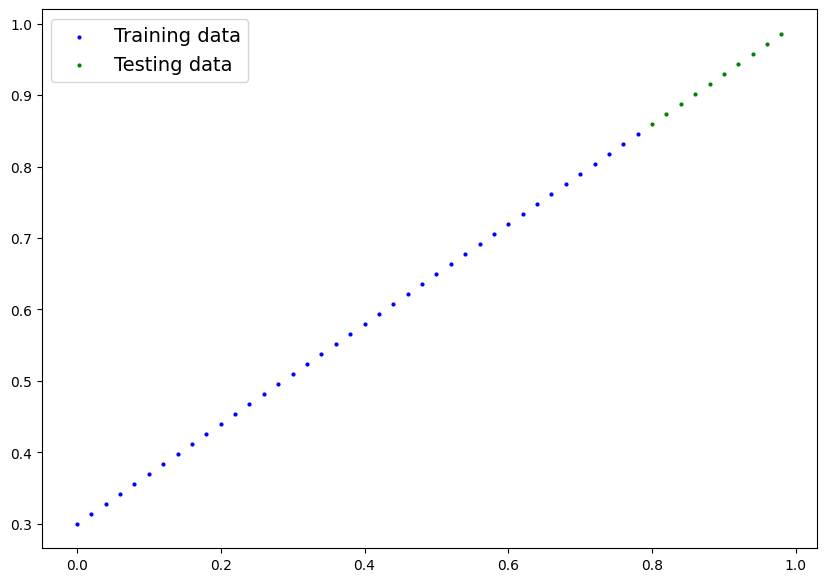

In [100]:
plot_predictions()

## 2. Build model

What the model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight and bias used to create the data)

It achieves this through:
* Gradient descent algorithm
* Backpropagation algorithm

In [101]:
# Create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherits from nn.Module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor: # x is the input data
        return self.weights * x + self.bias  # this is the linear regression formula

### PyTorch model building essentials

* torch.nn - contains all building blocks for computational graphs (nn's are computational graphs)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these
* torch.nn.Module - the base class for all neural network modules, overwrite forward() method when subclassing
* torch.optim - this is where the optimizers are kept, they help with gradient descent
* def forward() - defines what happens in the forward computation

### Checking the contents of the model

In [102]:
# Create a random seed
RANDOM_SEED = 143
torch.manual_seed(RANDOM_SEED)

model_0 = LinearRegressionModel()

# Check the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.6339], requires_grad=True),
 Parameter containing:
 tensor([-0.3374], requires_grad=True)]

In [103]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.6339])), ('bias', tensor([-0.3374]))])

### Making prediction using `torch.inference_mode()`

To check the model's predictive power, see how well it predicts 'y_test' based on 'X_test'

In [104]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)
    
y_preds

tensor([[0.1697],
        [0.1824],
        [0.1951],
        [0.2078],
        [0.2205],
        [0.2331],
        [0.2458],
        [0.2585],
        [0.2712],
        [0.2839]])

In [105]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

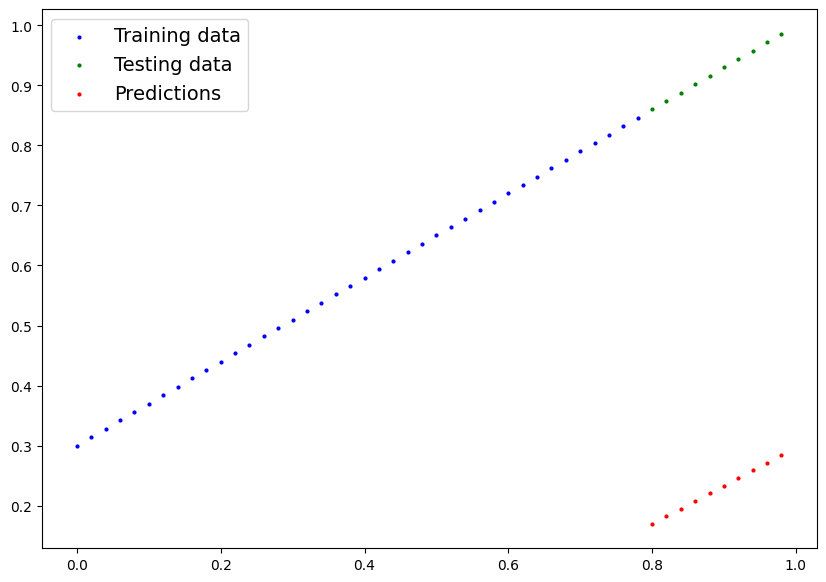

In [106]:
plot_predictions(predictions=y_preds)

## 3. Train model

Move from some unknown parameters to some known parameters (from poor representation to better representation)

One way to measure predictions is to use a loss function

Things to train:
**Loss Function**: A function to measure how wrong your model's predictions are to the ideal outputs, lower is better
**Optimizer**: Takes into account the loss of a model and adjusts the model's parameters (i.e. weight & bias)

for PyTorch:
* A training loop
* A testing loop

In [107]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

### Building a training loop and testing loop in PyTorch
  
1. Loop through the data
2. Forward pass (forward propagation) to make predictions on data
3. Calculate the loss - compare forward pass predictions to ground truth labels
4. Optimizer zero grad
5. Loss backward - moves backwards through the network to calculate the gradients of each of the parameters with respect to loss (**backpropagation**)
6. Optimizer step - use the optimizer to adjust the model's parameters to try and improve the loss (**gradient descent**)

In [108]:
# An epoch is one loop through the data
epochs = 200  # hyperparameter!

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

# 1. Loop through the data
for epoch in range(epochs):
    # Set the model to training mode
    model_0.train()  # train mode in PyTorch sets all parameters that require gradients to require gradients
    
    # 2. Forward pass
    y_pred = model_0(X_train)
    
    # 3. Calculate the loss
    loss = loss_fn(y_pred, y_train)
    
    # 4. Optimizer zero grad
    optimizer.zero_grad()
    
    # 5. Backpropagation
    loss.backward()
        
    # 6. Gradient descent
    optimizer.step()  # by default, how the optimizer changes will accumulate through the loop
    
    ### Testing
    # 1. Set to test (evaluation) mode
    model_0.eval()  # turns off gradient tracking
    with torch.inference_mode():
        # 2. Do the forward pass
        test_pred = model_0(X_test)
        
        # 3. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)
    
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
        print(model_0.state_dict())

Epoch: 0 | Loss: 0.6631713509559631 | Test loss: 0.6827258467674255
OrderedDict([('weights', tensor([0.6378])), ('bias', tensor([-0.3274]))])
Epoch: 10 | Loss: 0.5479615330696106 | Test loss: 0.5480159521102905
OrderedDict([('weights', tensor([0.6768])), ('bias', tensor([-0.2274]))])
Epoch: 20 | Loss: 0.43275147676467896 | Test loss: 0.4133060574531555
OrderedDict([('weights', tensor([0.7158])), ('bias', tensor([-0.1274]))])
Epoch: 30 | Loss: 0.3175415098667145 | Test loss: 0.27859607338905334
OrderedDict([('weights', tensor([0.7548])), ('bias', tensor([-0.0274]))])
Epoch: 40 | Loss: 0.2023315131664276 | Test loss: 0.14388622343540192
OrderedDict([('weights', tensor([0.7938])), ('bias', tensor([0.0726]))])
Epoch: 50 | Loss: 0.08712156116962433 | Test loss: 0.009756917133927345
OrderedDict([('weights', tensor([0.8328])), ('bias', tensor([0.1726]))])
Epoch: 60 | Loss: 0.030713040381669998 | Test loss: 0.06093255802989006
OrderedDict([('weights', tensor([0.8448])), ('bias', tensor([0.2321

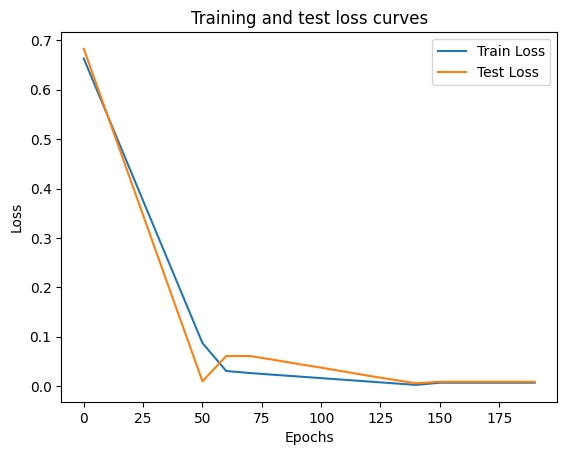

In [109]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.title("Training and test loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [110]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

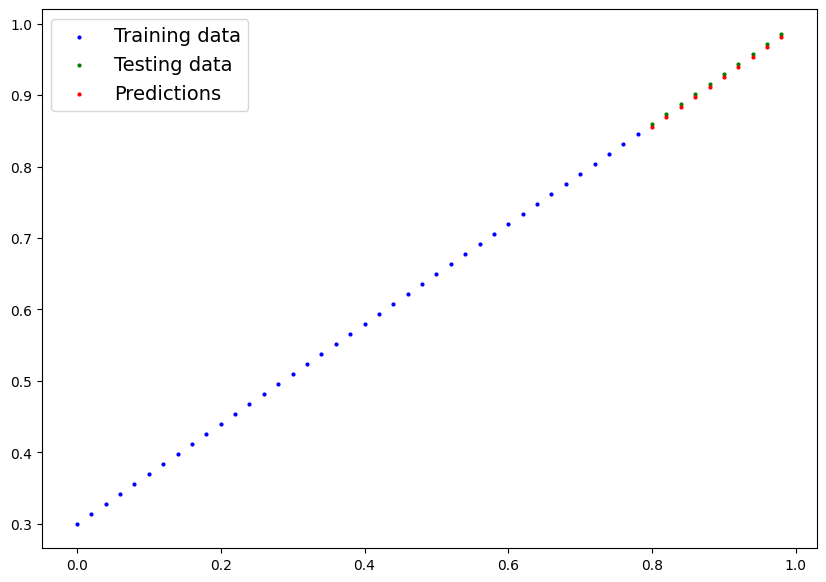

In [111]:
plot_predictions(predictions=y_preds_new)

## Saving a model in PyTorch
